In [1]:
# Import data
import matplotlib.pyplot as plt
import time
import tensorflow as tf
import numpy as np
import scipy.io

# User Functions
def yes_no(question):
    answer = 0
    while answer == 0:
        answer_data = input(question)
        if answer_data == 'y' or answer_data == 'n':
            answer = 1
        else:
            print('Try again')
    return answer_data

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

def weight_variable(name, shape_in):
    return tf.get_variable(name,shape=shape_in, initializer=tf.contrib.layers.xavier_initializer())
def bias_variable(name, shape_in):
    return tf.get_variable(name,shape=shape_in, initializer=tf.contrib.layers.xavier_initializer())

/opt/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
mat_data_train = scipy.io.loadmat('MNIST_data_train_re.mat')
mat_data_test = scipy.io.loadmat('MNIST_data_test_re.mat')

X_train = mat_data_train['X_train']
Y_train = mat_data_train['Y_train']
X_test = mat_data_test['X_test']
Y_test = mat_data_test['Y_test']

del mat_data_train
del mat_data_test

print('training data\n'+str(np.shape(X_train))+str(np.shape(Y_train))+'\ntesting data\n'+str(np.shape(X_test))+str(np.shape(Y_test)))

training data
(55000, 112, 112)(55000, 10)
testing data
(10000, 112, 112)(10000, 10)


In [3]:
tf.reset_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.InteractiveSession(config=config)

# CNN parameters
input_size_1 = 112
input_size_2 = 112
label_num = 10

num_cell = 512
num_step = 28
num_input = 28

num_fc1 = 256

conv1_output_channel = 32
conv2_output_channel = 32

window_size = 28
window_move = 14
window_step = [int((input_size_1-window_size)/window_move+1), int((input_size_2-window_size)/window_move+1)]

print(window_step)

def LSTM_cell(C_prev, h_prev, x, Wf, bf, Wi, bi, Wc, bc, Wo, bo):
    input_concat = tf.concat([h_prev, x], axis=1)
    ft = tf.sigmoid(tf.matmul(input_concat, Wf) + bf)
    it = tf.sigmoid(tf.matmul(input_concat, Wi) + bi)
    Ct_tilda = tf.tanh(tf.matmul(input_concat, Wc) + bc)
    Ct = tf.multiply(ft, C_prev) + tf.multiply(it, Ct_tilda)
    ot = tf.sigmoid(tf.matmul(input_concat, Wo) + bo)
    ht = tf.multiply(ot, tf.tanh(Ct))
    return Ct, ht

def Attention_model(y, c, W_tanh):
    m = []
    for i in range(len(y)):
        m.append(tf.tanh(tf.matmul(tf.concat([y[i], c], axis=1), W_tanh)))
    m_array = tf.concat([m[i] for i in range(len(y))], axis = 1)
    s = tf.nn.softmax(m_array)
    z = tf.reduce_sum([y[i]*tf.slice(s, begin=[0, i], size=[-1, 1]) for i in range(len(y))], axis = 0)
    return s, z

with tf.device('/gpu:1'):
    x = tf.placeholder(tf.float32, shape=[None, input_size_1, input_size_2])
    y_ = tf.placeholder(tf.float32, shape=[None, label_num])
    lr = tf.placeholder(tf.float64)

    batch_num = tf.shape(x)[0]
    
    x_image = tf.reshape(x,[-1, input_size_1, input_size_2, 1])
    
    model_a = []
    
    for i in range(window_step[0]):
        for j in range(window_step[1]):
            model_a.append(tf.slice(x_image, begin=[0, window_move*i, window_move*j, 0], size=[-1, window_size, window_size, -1]))
    
    W_conv1 = weight_variable('W_conv1',[5, 5, 1, conv1_output_channel])
    b_conv1 = bias_variable('b_conv1',[conv1_output_channel])
    
    W_conv2 = weight_variable('W_conv2',[5, 5, conv1_output_channel, conv2_output_channel])
    b_conv2 = bias_variable('b_conv2',[conv2_output_channel])

    
    model_conv_flat = []
    model_conv1 = []
    model_conv2 = []
    for i in range(len(model_a)):
        model_conv1.append(max_pool_2x2(tf.nn.relu(conv2d(model_a[i], W_conv1) + b_conv1)))
        model_conv2.append(max_pool_2x2(tf.nn.relu(conv2d(model_conv1[i], W_conv2) + b_conv2)))
        model_conv_flat.append(tf.contrib.layers.flatten(model_conv2[i]))
    
    attention_state_num = model_conv_flat[0].get_shape()[1]
    print(attention_state_num)
    attention_input_dim = attention_state_num + num_cell
    
    print(attention_input_dim)
    
    W_tanh = weight_variable('W_tanh1', [attention_input_dim, 1])
    
    Wf = weight_variable('Wf',[attention_input_dim, num_cell])
    Wi = weight_variable('Wi',[attention_input_dim, num_cell])
    Wc = weight_variable('Wc',[attention_input_dim, num_cell])
    Wo = weight_variable('Wo',[attention_input_dim, num_cell])
    bf = bias_variable('bf',[num_cell])
    bi = bias_variable('bi',[num_cell])
    bc = bias_variable('bc',[num_cell])
    bo = bias_variable('bo',[num_cell])    
    
    C_init = tf.zeros([batch_num, num_cell], dtype=tf.float32)
    h_init = tf.zeros([batch_num, num_cell], dtype=tf.float32)
    attention_c_init = tf.zeros([batch_num, num_cell], dtype=tf.float32)
    
    attention_s1, attention_z1 = Attention_model(model_conv_flat, attention_c_init, W_tanh)
    
    lstm_C1, lstm_h1 = LSTM_cell(C_init, h_init, attention_z1, Wf, bf, Wi, bi, Wc, bc, Wo, bo)
    
    attention_s2, attention_z2 = Attention_model(model_conv_flat, lstm_h1, W_tanh)
    
    lstm_C2, lstm_h2 = LSTM_cell(lstm_C1, lstm_h1, attention_z2, Wf, bf, Wi, bi, Wc, bc, Wo, bo)
    
    attention_s3, attention_z3 = Attention_model(model_conv_flat, lstm_h2, W_tanh)
    
    lstm_C3, lstm_h3 = LSTM_cell(lstm_C2, lstm_h2, attention_z3, Wf, bf, Wi, bi, Wc, bc, Wo, bo)
    
    attention_s4, attention_z4 = Attention_model(model_conv_flat, lstm_h3, W_tanh)
    
    lstm_C4, lstm_h4 = LSTM_cell(lstm_C3, lstm_h3, attention_z4, Wf, bf, Wi, bi, Wc, bc, Wo, bo)
    
#     lstm_out_concat = tf.concat([lstm_h1, lstm_h2, lstm_h3, lstm_h4], axis=1)
    
    W_out = weight_variable('W_out',[num_cell, label_num])
    b_out = bias_variable('b_out',[label_num])
    
    logits = tf.matmul(lstm_h4, W_out) + b_out    
    y_deep = tf.nn.softmax(logits)
    
    
#     W_out = weight_variable('W_out',[num_cell, label_num])
#     b_out = bias_variable('b_out',[label_num])
    
#     logits = tf.matmul(h, W_out) + b_out    
#     y_deep = tf.nn.softmax(logits)

    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=logits))
    train_step = tf.train.AdamOptimizer(lr).minimize(cross_entropy)
    # train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
    correct_prediction = tf.equal(tf.argmax(y_deep,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    

[7, 7]
1568
2080


In [5]:
load_name = 'model_04'
save_name = 'model_04'

sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()

load_flag = yes_no('Do you want to LOAD the trained variables? [y/n]')
if load_flag == 'y':
    save_path = './save/' + load_name
    saver.restore(sess, save_path)
    train_flag = yes_no('Do you want to TRAIN the data? [y/n]')
else:
    train_flag = 'y'


train_data_num = np.shape(X_train)[0]
m_test = np.shape(X_test)[0]

print(train_data_num,m_test)

batch_size = 256
nb_epoch = 3
# Trainning step
if train_flag == 'y':
    for i in range(nb_epoch):
        order = np.arange(train_data_num)
        np.random.shuffle(order)
        for batch_step in range(int(train_data_num/batch_size)+1):
            batch_idx = [batch_step*batch_size, (batch_step+1)*batch_size]
            if batch_idx[1] > train_data_num: batch_idx[1] = train_data_num
            batch_x = X_train[order[batch_idx[0]:batch_idx[1]],:,:]
            batch_y = Y_train[order[batch_idx[0]:batch_idx[1]],:]
#             print(np.shape(batch_x),np.shape(batch_y))
            train_step.run(feed_dict={x:batch_x, y_: batch_y, lr:0.000001})
            
            print_num = int((batch_step/(int(train_data_num/batch_size)+1))*30)
            print_string = "epoch %d/%d, ["%(i+1,nb_epoch)+"="*print_num+" "*(30-print_num) +"]"
            print(print_string, end="\r")

        batch_idx = np.random.choice(train_data_num,batch_size, replace = False)
        batch_x = X_train[batch_idx,:,:]
        batch_y = Y_train[batch_idx,:]
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_: batch_y})
        cost_value = cross_entropy.eval(feed_dict={x: batch_x, y_: batch_y})
        print("epoch %d/%d, cost= %g, training accuracy= %g"%(i+1, nb_epoch, cost_value, train_accuracy))
        save_path = './save/' + save_name
        saver.save(sess, save_path)

        # TEST accuracy calculation
        sample = batch_size
        temp_accuracy=np.zeros([int(m_test/sample)+1])
        for i in range(int(m_test/sample)+1):
            start = i*sample
            end = (i+1)*sample
            if end > m_test:
                end = m_test
            batch_x = X_test[start:end,:,:]
            batch_y = Y_test[start:end,:]
#             print(np.shape(batch_x),np.shape(batch_y))
            temp_temp = accuracy.eval(feed_dict={x: batch_x, y_: batch_y})
            temp_accuracy[i] = temp_temp * (end - start)
            # print("temp accuracy %g"%temp_temp)
        temp_accuracy = np.sum(temp_accuracy)/m_test
        print("test accuracy %g"%temp_accuracy)

Do you want to LOAD the trained variables? [y/n]y
INFO:tensorflow:Restoring parameters from ./save/model_04
Do you want to TRAIN the data? [y/n]y
55000 10000
epoch 1/3, cost= 0.137823, training accuracy= 0.960938
test accuracy 0.9556
epoch 2/3, cost= 0.174925, training accuracy= 0.941406
test accuracy 0.9562
epoch 3/3, cost= 0.106678, training accuracy= 0.96875
test accuracy 0.9556



Random data set 711
Test set label   = [0 0 0 0 0 1 0 0 0 0]
pred probability = [[ 0  0  0  0  0 99  0  0  0  0]]
pred number      = 5


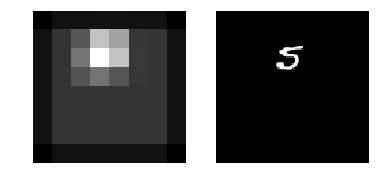

continue? or end? = 

Random data set 1566
Test set label   = [0 0 0 0 0 0 0 1 0 0]
pred probability = [[ 0  1  0  0  1  0  0 90  0  5]]
pred number      = 7


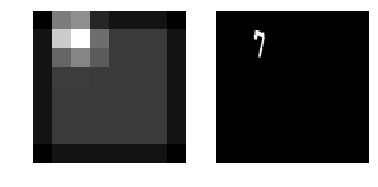

continue? or end? = 

Random data set 7901
Test set label   = [0 0 0 0 0 0 0 0 1 0]
pred probability = [[36  0  0  0  0  0  1  0 62  0]]
pred number      = 8


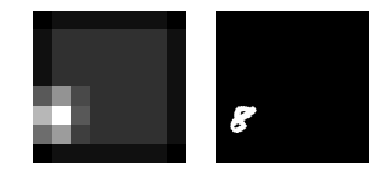

continue? or end? = 

Random data set 8238
Test set label   = [0 0 1 0 0 0 0 0 0 0]
pred probability = [[ 0  0 98  1  0  0  0  0  0  0]]
pred number      = 2


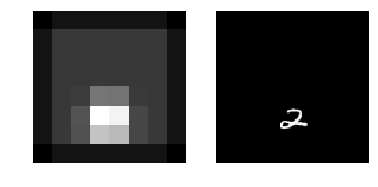

continue? or end? = 

Random data set 3730
Test set label   = [0 0 0 0 0 0 0 1 0 0]
pred probability = [[ 0  0  0  0  0  0  0 69  0 30]]
pred number      = 7


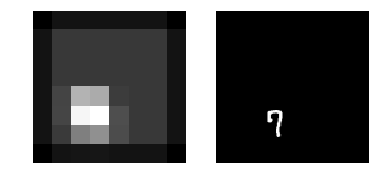

continue? or end? = 

Random data set 6882
Test set label   = [0 0 0 1 0 0 0 0 0 0]
pred probability = [[ 0  0  0 99  0  0  0  0  0  0]]
pred number      = 3


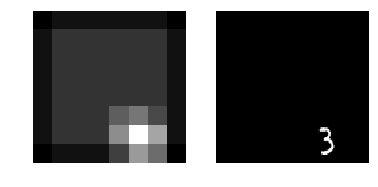

continue? or end? = 

Random data set 4941
Test set label   = [0 0 1 0 0 0 0 0 0 0]
pred probability = [[ 0  0 99  0  0  0  0  0  0  0]]
pred number      = 2


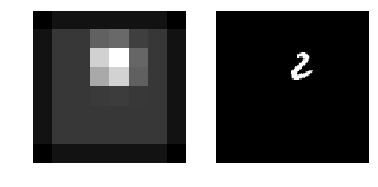

continue? or end? = 

Random data set 6238
Test set label   = [0 0 0 0 0 0 0 0 1 0]
pred probability = [[ 0  0  0  0  0  1  0  0 97  0]]
pred number      = 8


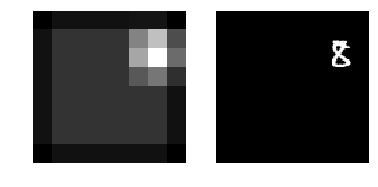

continue? or end? = 

Random data set 377
Test set label   = [0 1 0 0 0 0 0 0 0 0]
pred probability = [[ 0 99  0  0  0  0  0  0  0  0]]
pred number      = 1


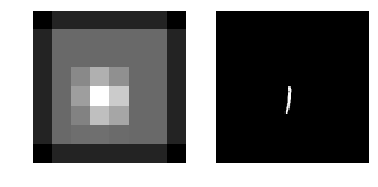

continue? or end? = 

Random data set 3577
Test set label   = [0 0 1 0 0 0 0 0 0 0]
pred probability = [[ 3  3 79  0  0 13  0  0  0  0]]
pred number      = 2


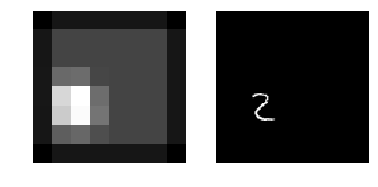

continue? or end? = 

Random data set 3772
Test set label   = [0 0 1 0 0 0 0 0 0 0]
pred probability = [[ 0  0 89  0  0  0  0  8  0  0]]
pred number      = 2


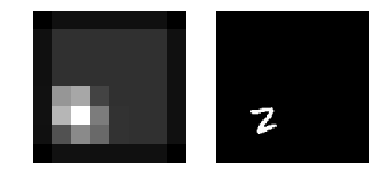

continue? or end? = 

Random data set 2547
Test set label   = [0 0 0 0 0 0 0 1 0 0]
pred probability = [[ 0  0  0  0  0  0  0 98  0  0]]
pred number      = 7


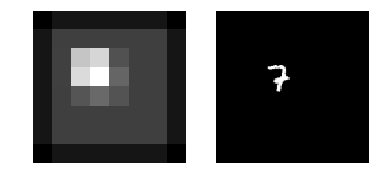

continue? or end? = end


In [6]:
test = 'go'
while test != 'end':
    temp_idx=np.random.randint(1,m_test)
    print('\nRandom data set '+str(temp_idx))
    print('Test set label   = '+str(np.int_(Y_test[temp_idx])))
    y_pre = sess.run(y_deep,feed_dict={x: X_test[temp_idx,:,:].reshape([1,input_size_1,input_size_2])})
    a_out = sess.run(model_a,feed_dict={x: X_test[temp_idx,:,:].reshape([1,input_size_1,input_size_2])})
    a_out = np.reshape(a_out, [window_step[0]*window_step[1], window_size, window_size])
    s1_out = sess.run(attention_s1,feed_dict={x: X_test[temp_idx,:,:].reshape([1,input_size_1,input_size_2])})
    s2_out = sess.run(attention_s2,feed_dict={x: X_test[temp_idx,:,:].reshape([1,input_size_1,input_size_2])})
    s3_out = sess.run(attention_s3,feed_dict={x: X_test[temp_idx,:,:].reshape([1,input_size_1,input_size_2])})
    s4_out = sess.run(attention_s4,feed_dict={x: X_test[temp_idx,:,:].reshape([1,input_size_1,input_size_2])})
    s1_image = np.reshape(s1_out,[window_step[0], window_step[1]])
    s2_image = np.reshape(s2_out,[window_step[0], window_step[1]])
    s3_image = np.reshape(s3_out,[window_step[0], window_step[1]])
    s4_image = np.reshape(s4_out,[window_step[0], window_step[1]])
    
    heat_map = np.zeros([input_size_1,input_size_1])
    for i in range(window_step[0]):
        for j in range(window_step[1]):
            heat_map[window_move*i:(window_move*i+window_size),window_move*j:(window_move*j+window_size)] = \
                heat_map[window_move*i:(window_move*i+window_size),window_move*j:(window_move*j+window_size)] + \
                np.ones([window_size,window_size])*s3_image[i,j] + np.ones([window_size,window_size])*s4_image[i,j] + \
                np.ones([window_size,window_size])*s1_image[i,j] + np.ones([window_size,window_size])*s2_image[i,j]
    heat_map = heat_map/np.max(heat_map)

    print('pred probability = '+str(np.int_(y_pre*100)))
    print('pred number      = '+str(np.argmax(y_pre[0,:])))
    
    f1, axarr1 = plt.subplots(1,2)
    axarr1[0].imshow(heat_map, cmap='gray')
    axarr1[0].axis("off")
    axarr1[1].imshow(X_test[temp_idx,:,:], cmap='gray')
    axarr1[1].axis("off")
    
    plt.show() 
    
    test = input('continue? or end? = ')
    
